<a href="https://colab.research.google.com/github/Saurabhbaghel/layout-preserving-ocr/blob/main/layout_preserving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget -i /content/drive/MyDrive/sample_images.txt

In [ ]:
!pip install "layoutparser[paddledetection]"
!pip install layoutparser torchvision
!pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install "layoutparser[ocr]"
!pip install python-doctr[torch]
!sudo apt install tesseract-ocr
!sudo apt-get install poppler-utils
# Install some free fonts for result rendering
!sudo apt-get install fonts-freefont-ttf -y
!pip install tensorflow-addons

In [ ]:
! pip install --upgrade pillow==6.2.2

In [1]:
import os
import cv2
import  layoutparser as lp
os.environ['USE_TORCH'] = '1'

from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import numpy as np
from detectron2.utils.logger import setup_logger
setup_logger()
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
class CCoco:
  def __init__(self) -> None:
    self.category_id = {"ocr_sent":1,"ocr_tab":2,"ocr_eq":3,"ocr_im":4}
    self.complete: dict[list[dict],list[dict]] = {}
    self.images: list[dict] = []
    self.image_id = 0
    self.annotations: list[dict] = []

  def add_to_images(self,complete_filename,height,width):
      filename = os.path.basename(complete_filename)
      self.images.append(
          {
              "id":self.image_id,
              "file_name":filename,
              "height": height,
              "width": width
          }
      )
      

  def add_to_annotations(self,category:str,bbox:str):
      self.annotations.append(
          {
              "id": self.image_id,
              "image_id": self.image_id,
              "category_id": self.category_id[category],
              "bbox": bbox
          }
      )

  def get_coco(self):
    self.complete["images"] = self.images
    self.complete["annotations"] = self.annotations

    return self.complete


In [26]:



def get_layout_objs(image_name,nms_thresh):
  image=cv2.imread(image_name)
 
  # Equations
  model = lp.Detectron2LayoutModel(
              config_path ='https://www.dropbox.com/s/ld9izb95f19369w/config.yaml?dl=1', # In model catalog
              label_map   ={1: "Equation"}, # In model`label_map`
              extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
          )
  layout=model.detect(image)
  lp.draw_box(image,layout,show_element_type=True)

  eq_blocks = lp.Layout([b for b in layout if b.type=='Equation'])

  # Tables
 
  model = lp.Detectron2LayoutModel(
              config_path = 'lp://TableBank/faster_rcnn_R_50_FPN_3x/config', # In model catalog
              label_map   = {0: "Table"}, # In model`label_map`
              extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
          )
  layout = model.detect(image)
  # lp.draw_box(image,layout,show_element_type=True)

  tb_blocks = lp.Layout([b for b in layout if b.type=='Table'])

  # DocBank

  config_file_path = "/content/drive/MyDrive/X101.yaml"
  weights_path = "/content/drive/MyDrive/docbank.pth"
  cfg = get_cfg()
  cfg.merge_from_file(config_file_path)
  cfg.MODEL.WEIGHTS = weights_path
  predictor = DefaultPredictor(cfg)
  outputs = predictor(image)
  print(outputs["instances"].pred_classes)
  print(outputs["instances"].pred_boxes)
  
  # Layout
  model = lp.Detectron2LayoutModel(
              config_path = 'https://www.dropbox.com/s/yc92x97k50abynt/config.yaml?dl=1', # In model catalog
              label_map   = {1:"Text", 2:"Image", 3:"Table", 4:"Maths", 5:"Separator", 6:"Other"}, # In model`label_map`
              extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.4] # Optional
          )
  layout=model.detect(image)
  lp.draw_box(image,layout,show_element_type=True)
  text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
  figure_blocks = lp.Layout([b for b in layout if b.type=='Image'])
  text_blocks = lp.Layout([b for b in text_blocks \
                    if not any(b.is_in(b_fig) for b_fig in figure_blocks)])
  
  ocr_agent = lp.TesseractAgent(languages='eng')
      # Initialize the tesseract ocr engine. You might need
      # to install the OCR components in layoutparser:
      # pip install layoutparser[ocr]
  
  images = figure_blocks.to_dict()['blocks']
  eqs = eq_blocks.to_dict()['blocks']
  tables = tb_blocks.to_dict()['blocks']
  
  layout_objs = []
  table_objs = []
  equation_objs = []

  for img in images:
      layout_objs.append(((int(img['x_1']),int(img['x_2']),int(img['y_1']),int(img['y_2'])),img['type']))
  for table in tables:
      layout_objs.append((( int(table['x_1']) ,int(table['x_2']),int(table['y_1']),int(table['y_2'])),table['type']))
      table_objs.append((( int(table['x_1']) ,int(table['x_2']),int(table['y_1']),int(table['y_2'])),table['type']))
  for equation in eqs:
      layout_objs.append((( int(equation['x_1']), int(equation['x_2']), int(equation['y_1']), int(equation['y_2'])),equation['type']))
      equation_objs.append((( int(equation['x_1']), int(equation['x_2']), int(equation['y_1']), int(equation['y_2'])),equation['type']))
  return layout_objs



def get_doctr_objs(filename):
  doc = DocumentFile.from_images(filename)
  predictor = ocr_predictor(pretrained = True)
  res = predictor(doc)
  res.show(doc)
  return res.export()


def iou(a, b):
  x1 = max(a[0], b[0])
  y1 = max(a[2], b[2])
  x2 = min(a[1], b[1])
  y2 = min(a[3], b[3])

  # AREA OF OVERLAP - Area where the boxes intersect
  width = (x2 - x1)
  height = (y2 - y1)
  # handle case where there is NO overlap
  if (width<0) or (height <0):
      return 0
  area_overlap = width * height

  # COMBINED AREA
  area_a = (a[1] - a[0]) * (a[3] - a[2])
  area_b = (b[1] - b[0]) * (b[3] - b[2])
  area_combined = area_a + area_b - area_overlap

  # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
  iou = area_overlap / (area_combined)
  return iou




def image_main(image_coco,filename):
  NMS_THRESH = 0.001
  lobjs = get_layout_objs(filename,NMS_THRESH)
  # print(lobjs)
  res = get_doctr_objs(filename)    
  img = cv2.imread(filename)
  h,w = img.shape[:-1]
  
  # to get coco format
  image_coco.add_to_images(filename,h,w)
 
  #start writing hocr
  header = f'''
    <?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
    <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
    <head>
    <title>
    </title>
    <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
    <meta content="tesseract 5.0.0-alpha-20201231-256-g73a32" name="ocr-system"/>
    <meta content="ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf" name="ocr-capabilities"/>
    </head>
    <body>
    <div class="ocr_page" id="page_1" title='image "{filename}"; bbox 0 0 {h} {w}; ppageno 0'>
    '''
  hocr=""
  hocr+=header
   #for all layoutblocks 

  TEXT_NMS_THRESH=0.02
  NMS_THRESH = 0.0007
  text_added_status = {}
  block_ind = 0
  for doc_blk in res['pages'][0]['blocks']:
      index = 0
      text_added_status[block_ind] = {} 
      for line in doc_blk['lines']:
        text_added_status[block_ind][index] = [True,None]
        index+=1
      block_ind+=1

  # print(text_added_status)

  for b in lobjs:
    added = False
    block_ind = 0
    for doc_blk in res['pages'][0]['blocks']:
      index = 0
      lp_blk = [b[0][0]/w, b[0][1]/w , b[0][2]/h, b[0][3]/h]
      for line in doc_blk['lines']:
        # NMS with least priority to Prima Layout Model  
        iouval = iou((line['geometry'][0][0],line['geometry'][1][0],line['geometry'][0][1],line['geometry'][1][1]),lp_blk)
        if(iouval>=NMS_THRESH):
          if not added:
            text_added_status[block_ind][index]=[False,b]
            added = True
          else:
            text_added_status[block_ind][index]=[False,None]
        index+=1
      block_ind+=1

  # print(text_added_status)
  block_ind = 0
  for doc_blk in res['pages'][0]['blocks']:
    index = 0
    for line in doc_blk['lines']:
      # print(text_added_status[block_ind][index][0])
      if text_added_status[block_ind][index][0]:
        # print("layoutout")
        # print(lp_blk)
        # print("line")
        # print(line)
        # print("iou")
        # print(iou((line['geometry'][0][0],line['geometry'][1][0],line['geometry'][0][1],line['geometry'][1][1]),lp_blk))
        sent=''
        blk = ''
        for word in line['words']:
          blk=blk+' '+word['value']
        bbox=str(int(line['geometry'][0][0]*w))+" "+str(int(line['geometry'][1][0]*w))+" "+str(int(line['geometry'][0][1]*h))+" "+str(int(line['geometry'][1][1]*h))
        sent = f'   <span class="ocr_sent" title="bbox {bbox};">{blk}\n'
        image_coco.add_to_annotations(category = 'ocr_sent', bbox = bbox)
        hocr+=sent
        # print("text")
        # print(blk)

      elif text_added_status[block_ind][index][1] is not None:
        if text_added_status[block_ind][index][1][1].find("Table")!=-1:
          coords = text_added_status[block_ind][index][1][0]
          tab = img[coords[2]:coords[3],coords[0]:coords[1],:]
          tab_name = f"{os.path.basename(filename)[:-4]}table{str(block_ind)+str(index)}.jpg"
          cv2.imwrite(tab_name,tab)
          sent = f'   <img class="ocr_tab" title="bbox {" ".join([str(i) for i in coords])} src="{tab_name}";> \n'
          image_coco.add_to_annotations(category = 'ocr_tab', bbox = bbox)
          hocr+=sent
        elif text_added_status[block_ind][index][1][1].find("Equation")!=-1:
          coords = text_added_status[block_ind][index][1][0]
          eq = img[coords[2]:coords[3],coords[0]:coords[1],:]
          eq_name = f"{os.path.basename(filename)[:-4]}table{str(block_ind)+str(index)}.jpg"
          cv2.imwrite(eq_name,eq)
          sent = f'   <img class="ocr_eq" title="bbox {" ".join([str(i) for i in coords])} src="{eq_name}";> \n'
          image_coco.add_to_annotations(category = 'ocr_eq', bbox = bbox)
          hocr+=sent
        elif text_added_status[block_ind][index][1][1].find("Image")!=-1:
          coords = text_added_status[block_ind][index][1][0]
          im = img[coords[2]:coords[3],coords[0]:coords[1],:]
          im_name = f"{os.path.basename(filename)[:-4]}table{str(block_ind)+str(index)}.jpg"
          cv2.imwrite(im_name,im)
          sent = f'   <img class="ocr_im" title="bbox {" ".join([str(i) for i in coords])} src="{im_name}";> \n'
          image_coco.add_to_annotations(category = 'ocr_im', bbox = bbox)
          hocr+=sent
      index+=1
    block_ind+=1
  # print(hocr)
  # return hocr
  return image_coco.get_coco()

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/layoutparser/visualization.py:392: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_w, text_h = font_obj.getsize(text)
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_p

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
DEBUG:tensorflow:Layer lstm_10 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_10 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_10 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_11 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_11 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_11 will use cuDNN kernels when running on GPU.


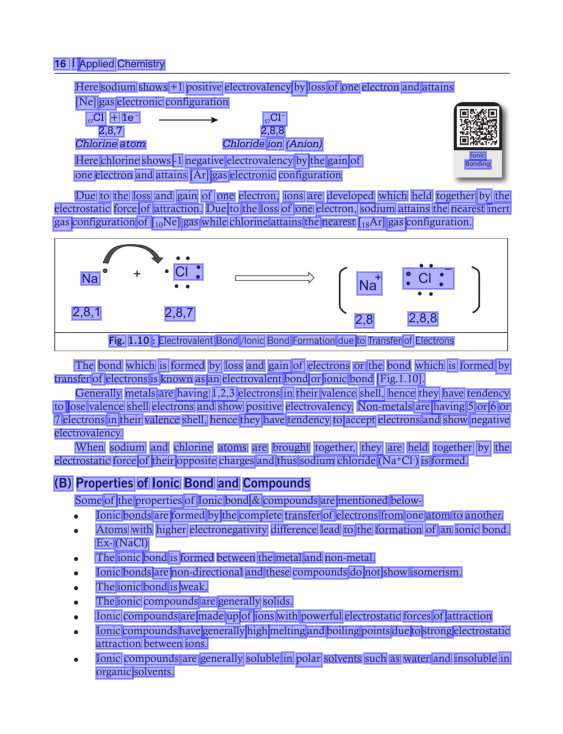


    <?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
    <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
    <head>
    <title>
    </title>
    <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
    <meta content="tesseract 5.0.0-alpha-20201231-256-g73a32" name="ocr-system"/>
    <meta content="ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf" name="ocr-capabilities"/>
    </head>
    <body>
    <div class="ocr_page" id="page_1" title='image "DIP121EN_Applied Chemistry 28-02-2022-0.jpg"; bbox 0 0 1900 1450; ppageno 0'>
       <span class="ocr_sent" title="bbox 123 416 133 168;"> 16 I Applied Chemistry
   <span class="ocr_sent" title="bbox 178 1179 194 233;"> Here sodium shows +1 positive electrovalency by loss of one electron and attains
   <span class="ocr_sent" title="bbox 179 584 233 270;"> [Ne] gas electronic configur

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
DEBUG:tensorflow:Layer lstm_12 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_12 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_12 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_13 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_13 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_13 will use cuDNN kernels when running on GPU.


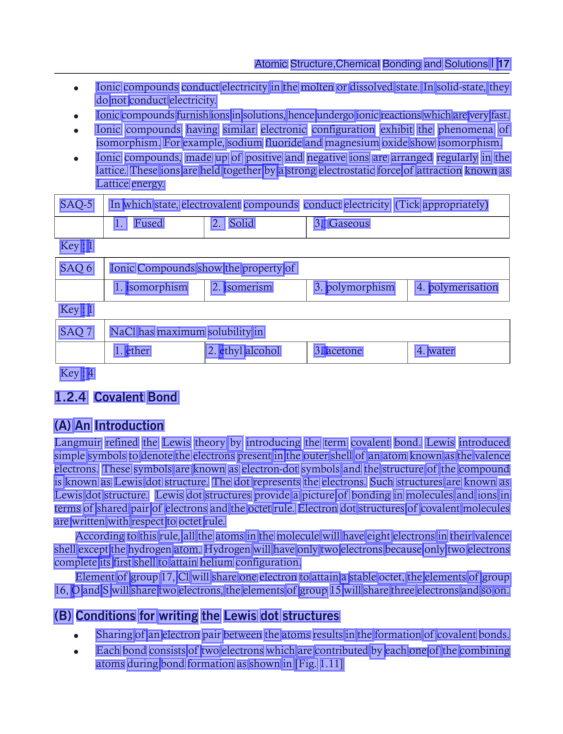


    <?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
    <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
    <head>
    <title>
    </title>
    <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
    <meta content="tesseract 5.0.0-alpha-20201231-256-g73a32" name="ocr-system"/>
    <meta content="ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf" name="ocr-capabilities"/>
    </head>
    <body>
    <div class="ocr_page" id="page_1" title='image "DIP121EN_Applied Chemistry 28-02-2022-0.jpg"; bbox 0 0 1900 1450; ppageno 0'>
       <span class="ocr_sent" title="bbox 654 1328 133 166;"> Atomic Structure,Chemical Bonding and Solutions I 17
   <span class="ocr_sent" title="bbox 233 1328 194 231;"> Ionic compounds conduct electricity in the molten or dissolved state. In solid-state, they
   <span class="ocr_sent" title="bbox 233 13

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
DEBUG:tensorflow:Layer lstm_14 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_14 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_14 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_15 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_15 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_15 will use cuDNN kernels when running on GPU.


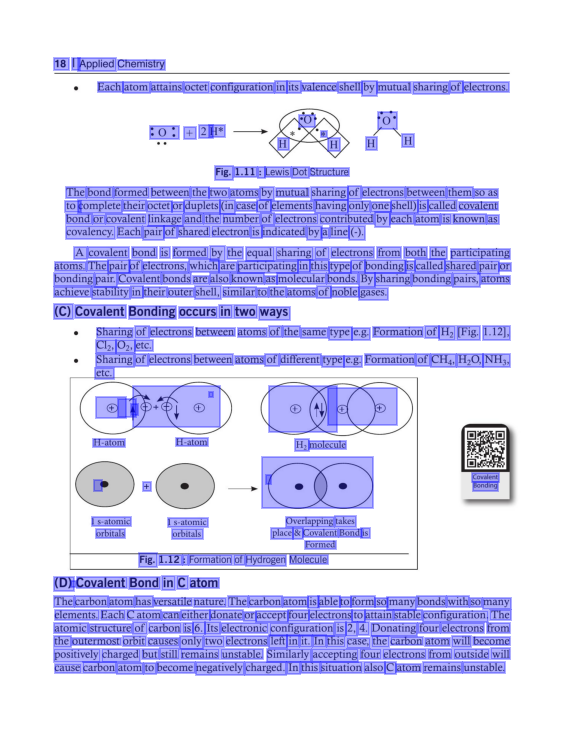


    <?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
    <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
    <head>
    <title>
    </title>
    <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
    <meta content="tesseract 5.0.0-alpha-20201231-256-g73a32" name="ocr-system"/>
    <meta content="ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf" name="ocr-capabilities"/>
    </head>
    <body>
    <div class="ocr_page" id="page_1" title='image "DIP121EN_Applied Chemistry 28-02-2022-0.jpg"; bbox 0 0 1900 1450; ppageno 0'>
       <span class="ocr_sent" title="bbox 123 416 133 168;"> 18 I Applied Chemistry
   <span class="ocr_sent" title="bbox 237 1322 194 233;"> Each atom attains octet configuration in its valence shell by mutual sharing of electrons.
   <img class="ocr_eq" title="bbox 407 1075 267 403 src="DIP121EN_Applied C

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
DEBUG:tensorflow:Layer lstm_16 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_16 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_16 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_17 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_17 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_17 will use cuDNN kernels when running on GPU.


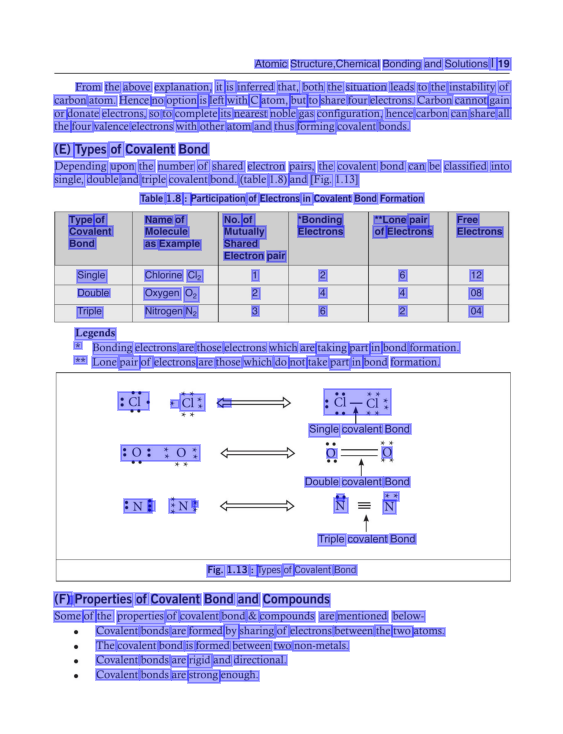


    <?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
    <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
    <head>
    <title>
    </title>
    <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
    <meta content="tesseract 5.0.0-alpha-20201231-256-g73a32" name="ocr-system"/>
    <meta content="ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf" name="ocr-capabilities"/>
    </head>
    <body>
    <div class="ocr_page" id="page_1" title='image "DIP121EN_Applied Chemistry 28-02-2022-0.jpg"; bbox 0 0 1900 1450; ppageno 0'>
       <span class="ocr_sent" title="bbox 654 1328 133 166;"> Atomic Structure,Chemical Bonding and Solutions I 19
   <span class="ocr_sent" title="bbox 181 1329 192 230;"> From the above explanation, it is inferred that, both the situation leads to the instability of
   <span class="ocr_sent" title="bbox 1

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
DEBUG:tensorflow:Layer lstm_18 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_18 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_18 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_19 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_19 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_19 will use cuDNN kernels when running on GPU.


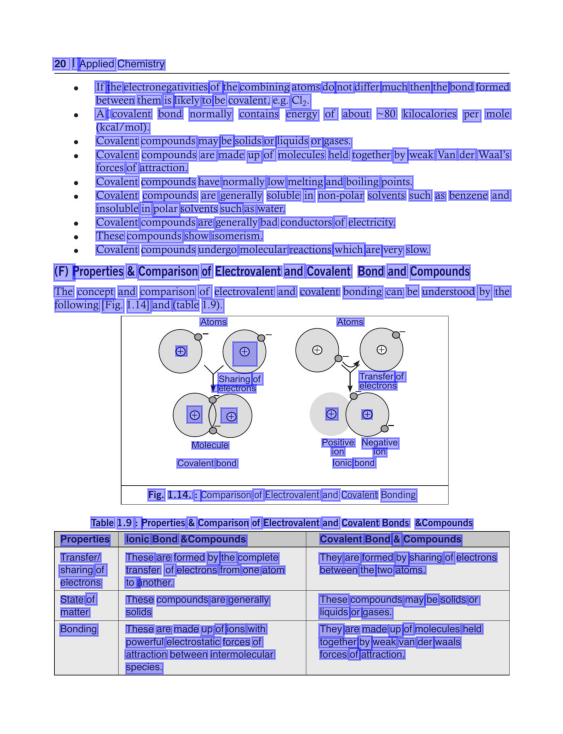


    <?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
    <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
    <head>
    <title>
    </title>
    <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
    <meta content="tesseract 5.0.0-alpha-20201231-256-g73a32" name="ocr-system"/>
    <meta content="ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf" name="ocr-capabilities"/>
    </head>
    <body>
    <div class="ocr_page" id="page_1" title='image "DIP121EN_Applied Chemistry 28-02-2022-0.jpg"; bbox 0 0 1900 1450; ppageno 0'>
       <span class="ocr_sent" title="bbox 120 416 133 168;"> 20 I Applied Chemistry
   <span class="ocr_sent" title="bbox 232 1325 194 228;"> If the clectronegativities of the combining atoms do not differ much then the bond formed
   <span class="ocr_sent" title="bbox 230 1328 265 302;"> A - covalent bond 

In [ ]:
# from pdf2image import convert_from_path

# images = convert_from_path("/content/Test44_48.pdf")
# idx = 0
# for i in images:
#   i.save("DIP121EN_Applied Chemistry 28-02-2022-"+str(idx)+".jpg","JPEG")
#   image_main("DIP121EN_Applied Chemistry 28-02-2022-"+str(idx)+".jpg")

In [ ]:
! wget https://raw.githubusercontent.com/doc-analysis/DocBank/master/DocBank_samples/DocBank_samples/102.tar_1705.05217.gz_final_report_3.jpg

--2022-12-15 08:02:42--  https://raw.githubusercontent.com/doc-analysis/DocBank/master/DocBank_samples/DocBank_samples/102.tar_1705.05217.gz_final_report_3.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538758 (526K) [image/jpeg]
Saving to: ‘102.tar_1705.05217.gz_final_report_3.jpg’

102.tar_1705.05217. 100%[===================>] 526.13K  --.-KB/s    in 0.004s  

2022-12-15 08:02:43 (146 MB/s) - ‘102.tar_1705.05217.gz_final_report_3.jpg’ saved [538758/538758]



config.yaml?dl=1: 8.19kB [00:02, 3.94kB/s]
model_final.pth?dl=1: 330MB [00:22, 14.9MB/s]                           
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
config.yaml?dl=1: 8.19kB [00:01, 5.71kB/s]
model_final.pth?dl=1: 330MB [00:22, 15.0MB/s]                           
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


config.yaml?dl=1: 8.19kB [00:01, 4.57kB/s]
model_final.pth?dl=1: 351MB [00:40, 8.73MB/s]                           
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/101971449 [00:00<?, ?it/s]

  0%|          | 0/63286381 [00:00<?, ?it/s]

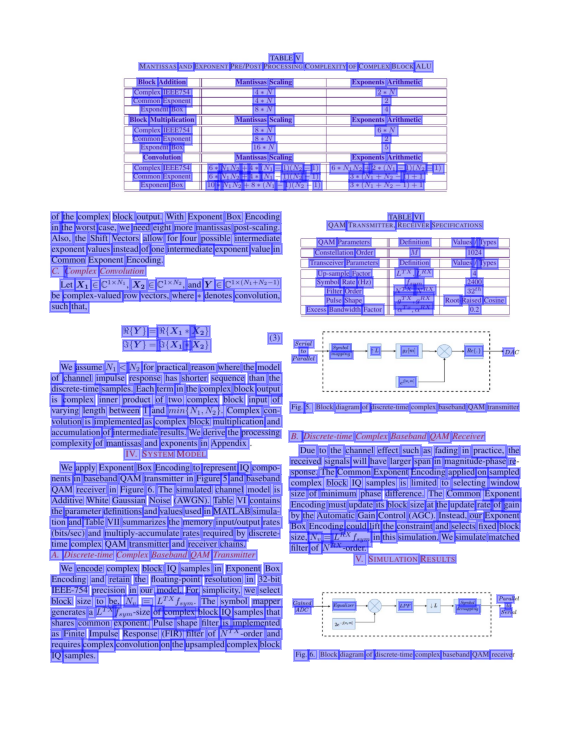


    <?xml version="1.0" encoding="UTF-8"?>
    <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
    <html lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
    <head>
    <title>
    </title>
    <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
    <meta content="tesseract 5.0.0-alpha-20201231-256-g73a32" name="ocr-system"/>
    <meta content="ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf" name="ocr-capabilities"/>
    </head>
    <body>
    <div class="ocr_page" id="page_1" title='image "/content/102.tar_1705.05217.gz_final_report_3.jpg"; bbox 0 0 2200 1700; ppageno 0'>
       <span class="ocr_sent" title="bbox 800 903 141 169;"> TABLE V
   <img class="ocr_tab" title="bbox 353 1339 213 560 src="102.tar_1705.05217.gz_final_report_3table01.jpg";> 
   <span class="ocr_sent" title="bbox 401 1301 165 197;"> MANTISSAS AND EXPONENT PRE/POST PROCESSING COMPLEXITY OF COMPLEX 

In [ ]:
image = '/content/102.tar_1705.05217.gz_final_report_3.jpg'
image_main(image)

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


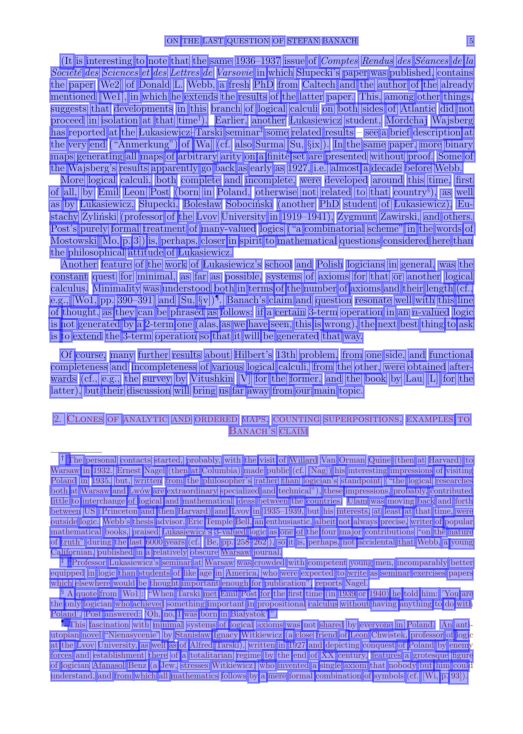

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


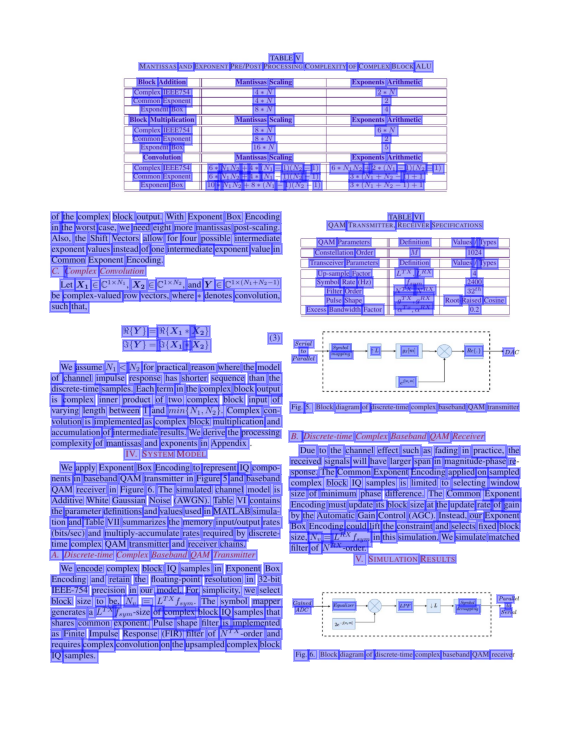

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


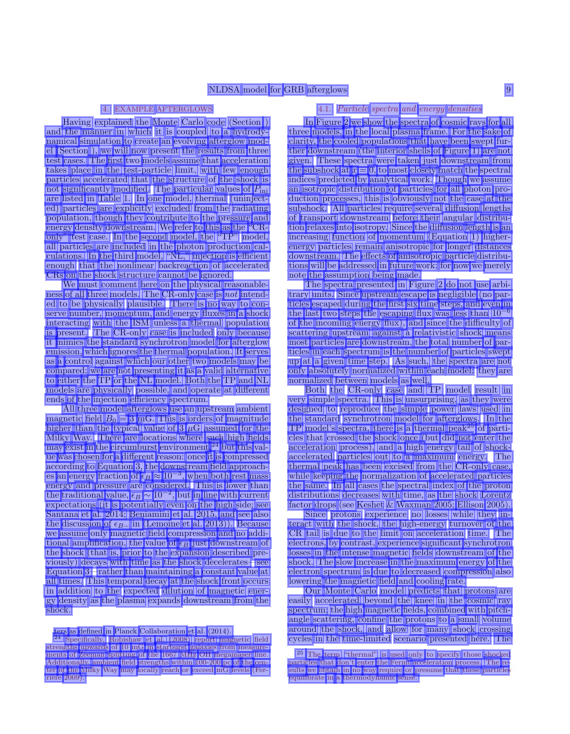

  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


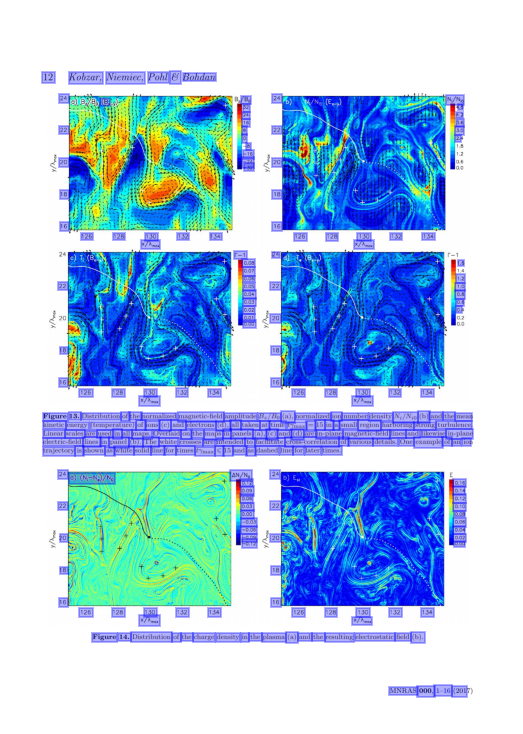

In [27]:
import glob
import os
dict_coco = {}

image_coco = CCoco()

for idx,img in enumerate(glob.glob('/content/*.jpg')):
  x = image_main(image_coco,img)
  image_coco.image_id+=1


In [29]:
import json

json.dump(x,open('/content/drive/MyDrive/coco_out.json','w'))